2024-07-09 21:26:00,245 - INFO - Data loaded successfully
c:\Users\Chris\miniconda3\envs\chrisenv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2367.770, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2388.845, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2360.399, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2359.806, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2386.922, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2363.830, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2360.383, Time=0.19 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2358.770, Time=0.20 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=2360.685, Time=0.28 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=2377.588, Time=0.13 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=2360.224, Time=0.22 sec
 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=2362.109, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2361.943, Time=0.14 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=2360.639, Time=0.67 sec
 ARIMA(0,1,1)(0,0,2

c:\Users\Chris\miniconda3\envs\chrisenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


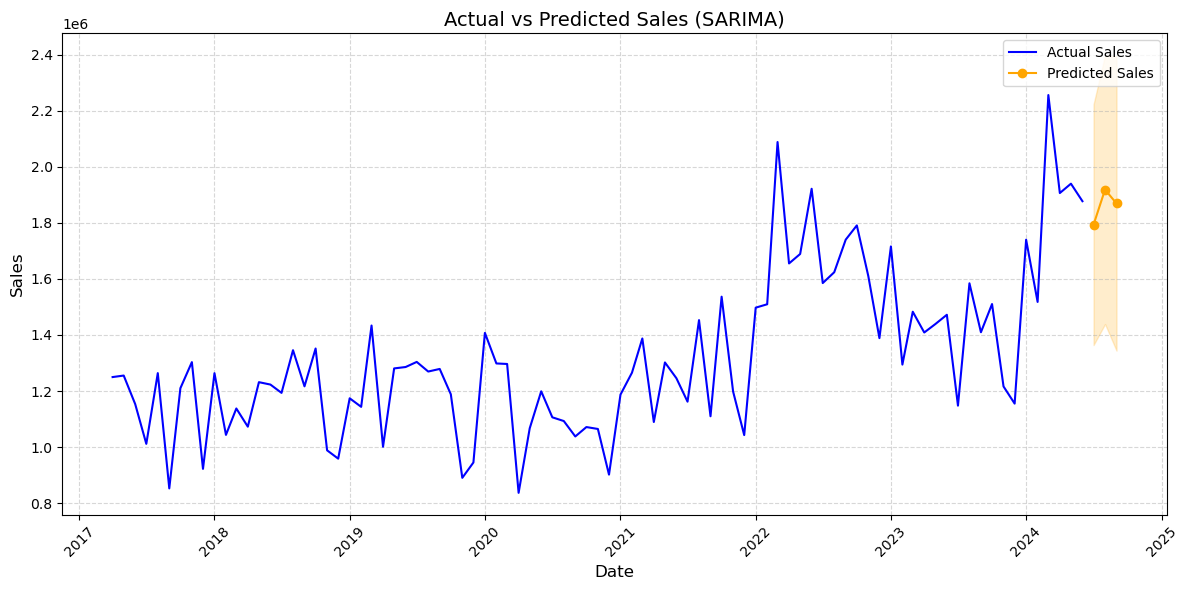

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_data(file):
    try:
        data = pd.read_csv(file)
        logging.info("Data loaded successfully")
        return data['date'].tolist(), data['sales'].tolist()
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

# Data extraction
file_path = 'data.csv'  # Update this path to the correct file location
date, sales = get_data(file_path)

# Convert date strings to datetime objects
date = pd.to_datetime(date)

# Create a DataFrame with date as index and sales as the column
sales_data = pd.DataFrame({'sales': sales}, index=date)

# Check for missing values or anomalies
if sales_data.isnull().sum().sum() > 0:
    logging.warning("Data contains missing values. Filling missing values with forward fill method.")
    sales_data = sales_data.ffill()

# Ensure the data is at monthly frequency
sales_data = sales_data.resample('MS').sum()

# Build the SARIMA model on the entire dataset
auto_model = auto_arima(
    sales_data,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # enables stepwise search to speed up
    max_p=3,        # restrict the range of p, d, q
    max_d=2,
    max_q=3,
    max_P=2,
    max_D=1,
    max_Q=2,
    maxiter=50,     # set max iterations
    n_jobs=-1       # use all available cores
)

sarima_model = SARIMAX(sales_data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
sarima_results = sarima_model.fit(disp=False)

# Make predictions for the next 3 months
pred_steps = 3
predictions = sarima_results.get_forecast(steps=pred_steps)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()

# Correctly extend the date index for the prediction period
extended_index = pd.date_range(start=sales_data.index[-1], periods=pred_steps + 1, freq='MS')[1:]
predicted_mean.index = extended_index
predicted_conf_int.index = extended_index

# Save predictions to Excel
predicted_data = pd.concat([predicted_mean, predicted_conf_int], axis=1)
predicted_data.columns = ['predicted_mean', 'lower_bound', 'upper_bound']
predicted_data.to_excel('predicted_sales.xlsx', index_label='Date')

# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(sales_data.index, sales_data['sales'], label='Actual Sales', color='blue')
plt.plot(predicted_mean.index, predicted_mean, label='Predicted Sales', color='orange', marker='o')
plt.fill_between(predicted_mean.index, predicted_conf_int.iloc[:, 0], predicted_conf_int.iloc[:, 1], color='orange', alpha=0.2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.title('Actual vs Predicted Sales (SARIMA)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()